# Sentence Transformer

In [1]:
import copy
import torch
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from transformers import DebertaV2Tokenizer, DebertaV2Model

from torch.utils.data import Dataset, DataLoader
from datasets import load_from_disk

In [2]:
import re
import string

In [3]:
import textstat
from spellchecker import SpellChecker
from lexical_density import lexical_density as Lexical_Density
from TF_IDF import calc_tf_idf
from Add_Periods import Add_Periods
from avg_word_sentence_length import average_word_length, average_sentence_length


## GPU

In [4]:
!nvidia-smi

Sun Oct  1 15:34:14 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070      WDDM  | 00000000:01:00.0  On |                  N/A |
| 28%   38C    P8              11W / 151W |   1904MiB /  8192MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Check if CUDA is available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Utils

In [6]:
def spell_checker_score(text, debug = False):
    def remove_punctuation(st):
        return re.sub(f"[{re.escape(string.punctuation)}]", '', st)
    
    spell = SpellChecker()
    misspelled = spell.unknown(remove_punctuation(text).split())

    if debug:
        for word in misspelled:
            # Get the one `most likely` answer
            print(f"{word} => {spell.correction(word)}")
        
        print(f"misspelled: {len(misspelled)}")
    return len(misspelled)

In [7]:
class DebertaV3Batch(torch.nn.Module):
    def __init__(self):
        super(DebertaV3Batch, self).__init__()
        # Load the tokenizer and model
        self.tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-base')
        self.model = DebertaV2Model.from_pretrained('microsoft/deberta-v3-base')
    

    def encode(self, sentences):
        # Tokenize sentences
        encoded_input = self.tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
        # Compute token embeddings
        with torch.no_grad():
            model_output = self.model(**encoded_input)

        # Only take the embeddings of the [CLS] token (or use the mean of the token embeddings if desired)
        sentence_embeddings = model_output.last_hidden_state[:, 0, :]
        
        return sentence_embeddings

In [8]:
class DebertaV3(torch.nn.Module):
    def __init__(self):
        super(DebertaV3, self).__init__()
        # Load the tokenizer and model
        self.tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-base')
        self.model = DebertaV2Model.from_pretrained('microsoft/deberta-v3-base')


    def sliding_window(self, text, window_size=512, overlap_size=256):
        tokenized_text = self.tokenizer(text, return_tensors="pt", truncation=False, padding=False)["input_ids"][0]
        windows = []
        for start_idx in range(0, len(tokenized_text) - window_size + 1, window_size - overlap_size):
            end_idx = start_idx + window_size
            windows.append(tokenized_text[start_idx:end_idx])
        return windows

    def process_windows(self, windows):
        embeddings = []
        for window in windows:
            inputs = {"input_ids": window.unsqueeze(0)}
            outputs = self.model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_embedding)
        return embeddings
    

    def encode(self, sentences):
        # Tokenize sentences
        encoded_input = self.tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
        # Compute token embeddings
        with torch.no_grad():
            model_output = self.model(**encoded_input)

        if len(encoded_input['input_ids'][0]) > 512:
            windows = self.sliding_window(sentences)
            window_embeddings = self.process_windows(windows)
            
            # Optionally, you can aggregate the window embeddings to get a single embedding for the entire text
            # For example, by averaging:
            average_embedding = torch.mean(torch.cat(window_embeddings), dim=0)
            return average_embedding
        else:
            # Only take the embeddings of the [CLS] token (or use the mean of the token embeddings if desired)
            sentence_embeddings = model_output.last_hidden_state[:, 0, :]
            
            return sentence_embeddings[0]

In [9]:
deberta = DebertaV3()
debertaBatch = DebertaV3Batch()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Generate dataset and batch

In [10]:
class PromptDataset(Dataset):

    def __init__(self, dataset, device):
        self.dataset = dataset
        self.device = device

    def deserialize_array(self, binary_string, dtype, shape):
        return np.frombuffer(binary_string, dtype=dtype).reshape(shape)

    def __getitem__(self, index):
        data = self.dataset[index]
        # retrieve values
        student_id = data['student_id']
        prompt_id = data['prompt_id']
        sentence = data['sentence']
        t_q_a_embeddings = torch.tensor(self.deserialize_array(data['t_q_a_embeddings'], np.float32, (768,))).to(self.device)
        embeddings_text = torch.tensor(self.deserialize_array(data['embeddings_text'], np.float32, (768,))).to(self.device)
        content = torch.tensor(data['content']).to(self.device)
        wording = torch.tensor(data['wording']).to(self.device)
        normalized_lexical_density = torch.tensor(data['normalized_lexical_density']).unsqueeze(0).to(self.device)
        normalized_spell_checker = torch.tensor(data['normalized_spell_checker']).unsqueeze(0).to(self.device)
        normalized_tf_idf_question_score = torch.tensor(data['normalized_tf_idf_question_score']).unsqueeze(0).to(self.device)
        normalized_avg_word_length = torch.tensor(data['normalized_avg_word_length']).unsqueeze(0).to(self.device)
        normalized_smog_index = torch.tensor(data['normalized_smog_index']).unsqueeze(0).to(self.device)
        normalized_coleman_liau_index = torch.tensor(data['normalized_coleman_liau_index']).unsqueeze(0).to(self.device)
        normalized_flesch_reading_ease = torch.tensor(data['normalized_flesch_reading_ease']).unsqueeze(0).to(self.device)
        
        return {
            'student_id': student_id,
            'prompt_id': prompt_id,
            'sentence': sentence,
            't_q_a_embeddings': t_q_a_embeddings,
            'embeddings_text': embeddings_text,
            'content': content,
            'wording': wording,
            'normalized_lexical_density': normalized_lexical_density,
            'normalized_spell_checker': normalized_spell_checker,
            'normalized_tf_idf_question_score': normalized_tf_idf_question_score,
            'normalized_avg_word_length': normalized_avg_word_length,
            'normalized_smog_index': normalized_smog_index,
            'normalized_coleman_liau_index': normalized_coleman_liau_index,
            'normalized_flesch_reading_ease': normalized_flesch_reading_ease,
        }

    def __len__(self) -> int :
        return self.dataset.num_rows

In [11]:
class DataLoaderFactory():

    def __init__(self, path:str = './data/hugging_face', batch_size = 12, device = 'cpu'):
        self.batch_size = batch_size
        self.dataset = load_from_disk(path, keep_in_memory=True)
        self.device = device

        print("1. Loading dataset: ...", end="")
        dataset = load_from_disk(path, keep_in_memory=True)
        print("\r1. Loading dataset: done ✔️")

        print("2. Split datasets: ...", end="")
        train_validation_splits = self.dataset['train'].train_test_split(test_size=0.2)
        print("\r2. Preprocess datasets: done ✔️")

        print("3. Split datasets: ...", end="")
        self.train_data = PromptDataset(train_validation_splits['train'], self.device)
        self.val_data = PromptDataset(train_validation_splits['test'], self.device)
        print("\r3. Split datasets: done ✔️")

        self.dataloader_train = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.dataloader_val = DataLoader(self.val_data, batch_size=batch_size, shuffle=True)
    
    
    def __len__(self) -> int :
        print("\033[95m\033[1m\033[4mNumber of data by datasets splits\033[0m")
        print(f"Train\t\t: {len(self.train_data)}\t-> {len(self.train_data)/self.batch_size}")
        print(f"Validation\t: {len(self.val_data)}\t\t-> {len(self.val_data)/self.batch_size}")
        total = len(self.train_data) + len(self.val_data)
        print(f"Total\t\t: {total}")
        return total

    def get_batch(self, split):
        # choose the correct dataloader
        if split == 'train':
            dataloader = self.dataloader_train
        else:
            dataloader = self.dataloader_val

        for batch in dataloader:
            # Move tensors to device
            batch_on_device = {k: v for k, v in batch.items()}
            yield batch_on_device

### Load the dataset

In [12]:
dataset = DataLoaderFactory(device=device)
len(dataset)

1. Loading dataset: done ✔️
2. Preprocess datasets: done ✔️
3. Split datasets: done ✔️
Number of data by datasets splits
Train		: 5732	-> 477.6666666666667
Validation	: 1433		-> 119.41666666666667
Total		: 7165


7165

### Testing the dataset

In [13]:
batch = dataset.get_batch('train')
nb = next(batch)

In [14]:
print(f"{'student_id:':<25}{len(nb['student_id'])}")
print(f"{'prompt_id:':<25}{len(nb['prompt_id'])}")
print(f"{'sentence:':<25}{len(nb['sentence'])}")
print(f"{'t_q_a_embeddings:':<25}{nb['t_q_a_embeddings'].shape}")
print(f"{'embeddings_text:':<25}{nb['embeddings_text'].shape}")
print(f"{'content:':<25}{nb['content'].shape}")
print(f"{'wording:':<25}{nb['wording'].shape}")
print(f"{'normalized_lexical_density:':<25}{nb['normalized_lexical_density'].shape}")
print(f"{'normalized_spell_checker:':<25}{nb['normalized_spell_checker'].shape}")
print(f"{'normalized_tf_idf_question_score:':<25}{nb['normalized_tf_idf_question_score'].shape}")
print(f"{'normalized_avg_word_length:':<25}{nb['normalized_avg_word_length'].shape}")
print(f"{'normalized_smog_index:':<25}{nb['normalized_smog_index'].shape}")
print(f"{'normalized_coleman_liau_index:':<25}{nb['normalized_coleman_liau_index'].shape}")
print(f"{'normalized_flesch_reading_ease:':<25}{nb['normalized_flesch_reading_ease'].shape}")

student_id:              12
prompt_id:               12
sentence:                12
t_q_a_embeddings:        torch.Size([12, 768])
embeddings_text:         torch.Size([12, 768])
content:                 torch.Size([12])
wording:                 torch.Size([12])
normalized_lexical_density:torch.Size([12, 1])
normalized_spell_checker:torch.Size([12, 1])
normalized_tf_idf_question_score:torch.Size([12, 1])
normalized_avg_word_length:torch.Size([12, 1])
normalized_smog_index:   torch.Size([12, 1])
normalized_coleman_liau_index:torch.Size([12, 1])
normalized_flesch_reading_ease:torch.Size([12, 1])


## Kaggle evaluation

### Paths

In [15]:
prompts_train_path = "./data/prompts_train.csv"
prompts_test_path = "./data/prompts_test.csv"

summaries_train_path = "./data/summaries_train.csv"
summaries_test_path = "./data/summaries_test.csv"

model_path = "./out/best_model_script.pt"

submission_path = "./out/submission.csv"

### Loading Model

In [16]:
exemple_batches = dataset.get_batch('train')
ex_batch = next(exemple_batches)
t_q_a_embeddings = ex_batch['t_q_a_embeddings']
embeddings_text = ex_batch['embeddings_text']

content = ex_batch['content']
wording = ex_batch['wording']

normalized_lexical_density = ex_batch['normalized_lexical_density']
normalized_spell_checker = ex_batch['normalized_spell_checker']
normalized_tf_idf_question_score = ex_batch['normalized_tf_idf_question_score']
normalized_avg_word_length = ex_batch['normalized_avg_word_length']
normalized_smog_index = ex_batch['normalized_smog_index']
normalized_coleman_liau_index = ex_batch['normalized_coleman_liau_index']
normalized_flesch_reading_ease = ex_batch['normalized_flesch_reading_ease']

features = (normalized_lexical_density.to(device), \
            normalized_spell_checker.to(device), \
            normalized_tf_idf_question_score.to(device), \
            normalized_avg_word_length.to(device), \
            normalized_smog_index.to(device), \
            normalized_coleman_liau_index.to(device), \
            normalized_flesch_reading_ease.to(device) \
           )

In [17]:
print(t_q_a_embeddings.shape)
for x in features:
    print(x.shape)

torch.Size([12, 768])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 1])
torch.Size([12, 1])


In [18]:
loaded_model = torch.jit.load(model_path).to(device)
loaded_model.eval()

RecursiveScriptModule(
  original_name=QA_Score_Model
  (fc_text): RecursiveScriptModule(original_name=Linear)
  (fc_t_q_a): RecursiveScriptModule(original_name=Linear)
  (fc_lexical): RecursiveScriptModule(original_name=Linear)
  (fc_spell): RecursiveScriptModule(original_name=Linear)
  (fc_tfidf): RecursiveScriptModule(original_name=Linear)
  (fc_avg_word_length): RecursiveScriptModule(original_name=Linear)
  (fc_smog): RecursiveScriptModule(original_name=Linear)
  (fc_coleman): RecursiveScriptModule(original_name=Linear)
  (fc_flesch): RecursiveScriptModule(original_name=Linear)
  (dropout): RecursiveScriptModule(original_name=Dropout)
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (out_content): RecursiveScriptModule(original_name=Linear)
  (out_wording): RecursiveScriptModule(original_name=Linear)
)

In [19]:
tensor1, tensor2 = loaded_model(embeddings_text, t_q_a_embeddings, features), torch.stack((content, wording), dim=1)

for (col1_tensor1, col2_tensor1), (col1_tensor2, col2_tensor2) in zip(tensor1, tensor2):
    print(f"[{col1_tensor1:>6.3f} => {col1_tensor2:>6.3f} = {col1_tensor2-col1_tensor1:>6.3f}] \t | \t [{col2_tensor1:>6.3f} => {col2_tensor2:>6.3f} = {col2_tensor2 - col2_tensor1:>6.3f}]")

[-1.087 => -0.798 =  0.289] 	 | 	 [-1.037 => -0.209 =  0.828]
[ 1.304 =>  1.986 =  0.683] 	 | 	 [ 1.141 =>  3.442 =  2.301]
[-0.461 => -0.602 = -0.141] 	 | 	 [-0.434 => -1.040 = -0.606]
[ 0.737 =>  1.221 =  0.484] 	 | 	 [ 0.741 =>  2.269 =  1.528]
[-1.107 => -1.547 = -0.440] 	 | 	 [-1.125 => -1.461 = -0.336]
[ 0.675 =>  0.168 = -0.507] 	 | 	 [ 0.101 =>  0.038 = -0.064]
[ 0.153 =>  0.206 =  0.052] 	 | 	 [ 0.312 =>  0.381 =  0.069]
[-1.097 => -1.547 = -0.450] 	 | 	 [-1.089 => -1.461 = -0.372]
[ 0.169 =>  0.536 =  0.367] 	 | 	 [ 0.082 => -0.585 = -0.667]
[-1.136 => -1.547 = -0.411] 	 | 	 [-1.125 => -1.461 = -0.337]
[ 1.240 => -0.094 = -1.333] 	 | 	 [ 1.144 =>  0.504 = -0.640]
[ 1.378 =>  1.788 =  0.410] 	 | 	 [ 1.076 =>  2.139 =  1.063]


### Load SentenceTransformer model

In [20]:
sentence_transformer_model = SentenceTransformer('all-mpnet-base-v2')

### Loading files

In [21]:
prompts_train = pd.read_csv(prompts_train_path)
prompts_test = pd.read_csv(prompts_test_path)

In [22]:
summaries_train = pd.read_csv(summaries_train_path)
summaries_test = pd.read_csv(summaries_test_path)

In [23]:
if len(prompts_test) == 2:
    prompts_test = prompts_train.copy()
    summaries_test = summaries_train.copy()

### Visualize datasets

In [24]:
prompts_test

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [25]:
summaries_test.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


### Inference

### Normilized function
usefull to normalize between -1 and 1 content and wording

In [26]:
def normalize_value(x, min=-2, max=4):
    return 2*((x-min)/(max-min))-1

inverse normalization

In [27]:
# def rescale(value, old_min=-1, old_max=1, new_min=-2, new_max=4):
#     return ((value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min

### Helpers

In [28]:
def to_numpy(var):
    if isinstance(var, torch.Tensor):
        return var.cpu().numpy()
    return var

### Preprocess_prompts
We do this separatly in order to preprocess only on time each row

In [29]:
def preprocess_prompts(prompts_df: pd.DataFrame) -> pd.DataFrame:
    # init an empty new  dataFrame
    new_data = pd.DataFrame({
        'prompt_id': [],
        'embeddings_text': [],
        'prompt_question': [],
        'prompt_title': [],
        'tf_idf': []
    })

    for index, row in prompts_df.iterrows():
        # retrieve columns
        prompt_id = row['prompt_id']
        prompt_question = row['prompt_question']
        prompt_title = row['prompt_title']
        prompt_text = row['prompt_text']

        tf_idf = calc_tf_idf(prompt_question, prompt_text, 10)

        # we are creating a batch of the sentences we want to get embeddings
        # sentences = [prompt_question, prompt_text]

        # calling model embedding
        # embeddings = sentence_transformer_model.encode(sentences)
        text_embeddings = deberta.encode(prompt_text).detach().numpy()

        # Create a new row
        new_row = pd.DataFrame({
            'prompt_id': [prompt_id],
            'embeddings_text': [text_embeddings],
            'tf_idf': [tf_idf],
            'prompt_title': [prompt_title],
            'prompt_question': [prompt_question],
            'prompt_text': [prompt_text]
        })
        
        # Append the row
        new_data = pd.concat([new_data.loc[:], new_row], ignore_index=True)

    return new_data

### Preprocess one row to create the input

In [30]:
def preprocess_batches(batch, prompts_df):
    results = []

    for index, row in batch.iterrows():
        # retrieve columns from summaries_df
        prompt_id = row["prompt_id"]
        answer = row["text"]
    
        # Data engineering
        # space behind period of end of sentence "Exemple end.Start new sentence text@gmail.com" = "Exemple end. Start new sentence text@gmail.com" 
        cleaned_answer = re.sub(r'(?<=\.)[A-Z]', r' \g<0>', answer)
        cleaned_answer = Add_Periods(cleaned_answer)
        
        # FK_grade, Gunning_Fog, SMOG = readability_scores(text)
        smog_index = getattr(textstat, 'smog_index')(cleaned_answer)
        coleman_liau_index = getattr(textstat, 'coleman_liau_index')(cleaned_answer)
        flesch_reading_ease = getattr(textstat, 'flesch_reading_ease')(cleaned_answer)
        
        lexical_density = Lexical_Density(cleaned_answer)
        spell_checker = spell_checker_score(cleaned_answer)
        
        avg_word_length = average_word_length(cleaned_answer)
    
        # Retrieving prompt infos
        prompt_row = prompts_df.loc[prompts_df['prompt_id'] == prompt_id]
            
        prompt_tf_idf, prompt_title, prompt_question, embeddings_text = prompt_row['tf_idf'].item(), \
                                                                        prompt_row['prompt_title'].item(), \
                                                                        prompt_row['prompt_question'].item(), \
                                                                        torch.tensor(prompt_row['embeddings_text'].item())
    
        # we are creating a full sentence containing the title, the question and this answer
        sep = deberta.tokenizer.sep_token
        sentence = prompt_title + sep + prompt_question + sep + answer
        
        # calling model embedding
        t_q_a_embeddings = torch.tensor(debertaBatch.encode(sentence))
        
        # Calculating tf_idf for prompt question and prompt text in relation with answere text word present in the text
        tf_idf = [word.lower() for word in prompt_tf_idf]
        tf_idf_question = [word.lower() for word in calc_tf_idf(prompt_question, cleaned_answer, 10)]
        
        # Calculate the score representing the number of words from prompt_tf_idf present in answer_tf_idf
        tf_idf_question_score = sum(word in tf_idf_question for word in tf_idf)
        
        # collect results into a list
        result = {
            'embeddings_text': embeddings_text.unsqueeze(0),
            't_q_a_embeddings': t_q_a_embeddings,
            'lexical_density': torch.tensor([[normalize_value(lexical_density, min=0, max=1)]]),
            'spell_checker': torch.tensor([[normalize_value(spell_checker, min=0, max=10)]]),
            'tf_idf_question_score': torch.tensor([[normalize_value(tf_idf_question_score, min=0, max=10)]]),
            'avg_word_length': torch.tensor([[normalize_value(avg_word_length, min=3, max=10)]]),
            'smog_index': torch.tensor([[normalize_value(smog_index, min=0, max=17)]]),
            'coleman_liau_index': torch.tensor([[normalize_value(coleman_liau_index, min=0, max=17)]]),
            'flesch_reading_ease': torch.tensor([[normalize_value(flesch_reading_ease, min=1, max=100)]]),
        }
        results.append(result)

    # Now stack or concatenate results together
    embeddings_text = torch.cat([result['embeddings_text'] for result in results]).to(device)
    t_q_a_embeddings = torch.cat([result['t_q_a_embeddings'] for result in results]).to(device)
    lexical_density = torch.cat([result['lexical_density'] for result in results]).to(device)
    spell_checker = torch.cat([result['spell_checker'] for result in results]).to(device)
    tf_idf_question_score = torch.cat([result['tf_idf_question_score'] for result in results]).to(device)
    avg_word_length = torch.cat([result['avg_word_length'] for result in results]).to(device)
    smog_index = torch.cat([result['smog_index'] for result in results]).to(device)
    coleman_liau_index = torch.cat([result['coleman_liau_index'] for result in results]).to(device)
    flesch_reading_ease = torch.cat([result['flesch_reading_ease'] for result in results]).to(device)

    features = (
        lexical_density,
        spell_checker,
        tf_idf_question_score,
        avg_word_length,
        smog_index,
        coleman_liau_index,
        flesch_reading_ease,
    )
    return embeddings_text, t_q_a_embeddings, features

In [31]:
def preprocess(row, prompts_df: pd.DataFrame):
    # retrieve columns from summaries_df
    prompt_id = row["prompt_id"]
    answer = row["text"]

    # Data engineering
    # space behind period of end of sentence "Exemple end.Start new sentence text@gmail.com" = "Exemple end. Start new sentence text@gmail.com" 
    cleaned_answer = re.sub(r'(?<=\.)[A-Z]', r' \g<0>', answer)
    cleaned_answer = Add_Periods(cleaned_answer)
    
    # FK_grade, Gunning_Fog, SMOG = readability_scores(text)
    smog_index = getattr(textstat, 'smog_index')(cleaned_answer)
    coleman_liau_index = getattr(textstat, 'coleman_liau_index')(cleaned_answer)
    flesch_reading_ease = getattr(textstat, 'flesch_reading_ease')(cleaned_answer)
    
    lexical_density = Lexical_Density(cleaned_answer)
    spell_checker = spell_checker_score(cleaned_answer)
    
    avg_word_length = average_word_length(cleaned_answer)

    # Retrieving prompt infos
    prompt_row = prompts_df.loc[prompts_df['prompt_id'] == prompt_id]
        
    prompt_tf_idf, prompt_title, prompt_question, embeddings_text = prompt_row['tf_idf'].item(), \
                                                                    prompt_row['prompt_title'].item(), \
                                                                    prompt_row['prompt_question'].item(), \
                                                                    torch.tensor(prompt_row['embeddings_text'].item())

    # we are creating a full sentence containing the title, the question and this answer
    sep = deberta.tokenizer.sep_token
    sentence = prompt_title + sep + prompt_question + sep + answer
    
    # calling model embedding
    t_q_a_embeddings = torch.tensor(debertaBatch.encode(sentence))
    
    # Calculating tf_idf for prompt question and prompt text in relation with answere text word present in the text
    tf_idf = [word.lower() for word in prompt_tf_idf]
    tf_idf_question = [word.lower() for word in calc_tf_idf(prompt_question, cleaned_answer, 10)]
    
    # Calculate the score representing the number of words from prompt_tf_idf present in answer_tf_idf
    tf_idf_question_score = sum(word in tf_idf_question for word in tf_idf)

    features = (
        torch.tensor([[normalize_value(lexical_density, min=0, max=1)]]).to(device), \
        torch.tensor([[normalize_value(spell_checker, min=0, max=10)]]).to(device), \
        torch.tensor([[normalize_value(tf_idf_question_score, min=0, max=10)]]).to(device), \
        torch.tensor([[normalize_value(avg_word_length, min=3, max=10)]]).to(device), \
        torch.tensor([[normalize_value(smog_index, min=0, max=17)]]).to(device), \
        torch.tensor([[normalize_value(coleman_liau_index, min=0, max=17)]]).to(device), \
        torch.tensor([[normalize_value(flesch_reading_ease, min=1, max=100)]]).to(device) \
       )

    return embeddings_text.unsqueeze(0).to(device), \
        t_q_a_embeddings.to(device), \
        features



### Inference

In [32]:
from tqdm import tqdm

In [33]:
def preprocess_batch(batch, prompts_df):
    # Assuming your preprocess function can handle batches
    embeddings_text, t_q_a_embeddings, features = preprocess_batches(batch, prompts_df)
    return embeddings_text, t_q_a_embeddings, features

In [34]:
def inference(summaries_df: pd.DataFrame, prompts_df: pd.DataFrame, batch_size=32):
        # preprocess prompt
        print(f"Prompts preprocessing: ...\r", end="")
        prompts_df = preprocess_prompts(prompts_df)
        print("Prompts preprocessing: done")
    
        # Placeholder lists to collect data
        student_ids, contents, wordings = [], [], []
        
        # Process in batches
        for i in tqdm(range(0, len(summaries_df), batch_size)):
            batch = summaries_df.iloc[i:i+batch_size]
            embeddings_text, t_q_a_embeddings, features = preprocess_batch(batch, prompts_df)
    
            # Assuming loaded_model can handle batches and outputs a list or array of results
            outputs = loaded_model(embeddings_text, t_q_a_embeddings, features)
            content, wording = zip(*[(output[0].detach().cpu().numpy(), output[1].detach().cpu().numpy()) for output in outputs])
            
            student_ids.extend(batch['student_id'].tolist())
            contents.extend(content)
            wordings.extend(wording)
    
        # Create DataFrame at the end
        new_data = pd.DataFrame({'student_id': student_ids, 'content': contents, 'wording': wordings})
        new_data.to_csv(submission_path, index=False)
        

In [35]:
# def inference(summaries_df: pd.DataFrame, prompts_df: pd.DataFrame):
#     new_data = pd.DataFrame({
#         'student_id': [],
#         'content': [],
#         'wording': []
#     })

#     # preprocess prompt
#     print(f"Prompts preprocessing: ...\r", end="")
#     prompts_df = preprocess_prompts(prompts_df)
#     print("Prompts preprocessing: done")
#     # Iterate over summaries
#     for index, row in summaries_df.iterrows():
#         print(f"\r{index+1}/{len(summaries_df)}", end="")
#         student_id = row['student_id']
        
#         embeddings_text, \
#         t_q_a_embeddings, \
#         features = preprocess(row, prompts_df)

#         outputs = loaded_model(embeddings_text, t_q_a_embeddings, features)
#         content, wording = outputs[0].detach().cpu().numpy()

#         new_row = pd.DataFrame({'student_id': [student_id], 'content': [content], 'wording': [wording]})

#         # Append the row
#         new_data = pd.concat([new_data.loc[:], new_row], ignore_index=True)
#     new_data.to_csv(submission_path, index=False)

In [36]:
inference(summaries_test, prompts_test)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Prompts preprocessing: done


  0%|                                                                                                                                                                                                                | 0/224 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
C:\Users\thiba\AppData\Local\Temp\ipykernel_31828\3980894004.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_q_a_embeddings = torch.tensor(debertaBatch.encode(sentence))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [49:32<00:00, 13.27s/it]


## checking hist

In [37]:
import matplotlib.pyplot as plt

In [38]:
xmin, xmax = -2, 4
ymin, ymax = 0, 2000

In [39]:
submission_file = pd.read_csv(submission_path)
submission_file

,student_id,content,wording
0,000e8c3c7ddb,1.255199,1.125555
1,0020ae56ffbf,-0.914497,-0.911038
2,004e978e639e,2.105297,1.481099
3,005ab0199905,-0.863367,-0.865948
4,0070c9e7af47,2.146088,1.238476
...,...,...,...
7160,ff7c7e70df07,-0.145996,-0.254882
7161,ffc34d056498,-0.285557,-0.375517
7162,ffd1576d2e1b,-0.915870,-0.951520
7163,ffe4a98093b2,0.123478,0.116966


In [40]:
df1 = summaries_test[["student_id", "content", "wording"]] # Real
df2 = submission_file # pred
# Setting 'student_id' as index
df1.set_index('student_id', inplace=True)
df2.set_index('student_id', inplace=True)

In [41]:
# Subtracting corresponding 'content' and 'wording' columns and creating a new DataFrame
df3 = pd.DataFrame()
df3['content'] = df1['content'] - df2['content']
df3['wording'] = df1['wording'] - df2['wording']
df3.reset_index(inplace=True)

print(df3)

        student_id   content   wording
0     000e8c3c7ddb -1.049517 -0.745017
1     0020ae56ffbf  0.366193  1.417793
2     004e978e639e  1.023632  2.750127
3     005ab0199905  0.652753  0.394533
4     0070c9e7af47  1.126806  1.981280
...            ...       ...       ...
7160  ff7c7e70df07  0.351678  0.635419
7161  ffc34d056498 -0.022891  0.423688
7162  ffd1576d2e1b -0.492309  0.457916
7163  ffe4a98093b2 -0.516788  0.510162
7164  fffbccfd8a08  1.395714  0.222774

[7165 rows x 3 columns]


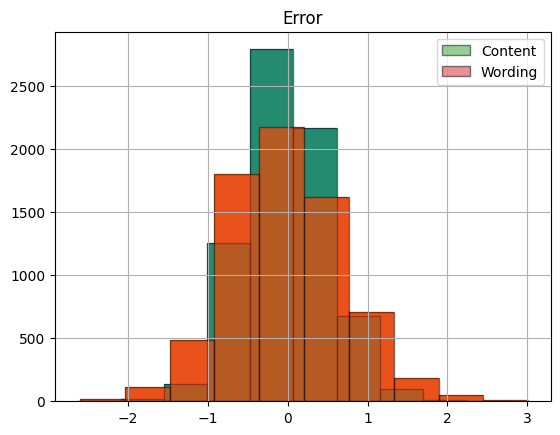

In [42]:
df3['content'].hist(), df3['wording'].hist()

df3['content'].hist(label='Content', alpha=0.5, edgecolor='k')
df3['wording'].hist(label='Wording', alpha=0.5, edgecolor='k')
# Adding a legend
plt.legend()
plt.title('Error')
plt.show()

In [43]:
def score(df):
    wdg = df[abs(df3['wording']) <= 0.1].count()['student_id'] * 100 / len(df)
    cnt = df[abs(df3['content']) <= 0.1].count()['student_id'] * 100 / len(df)

    print(f"Wording score : {wdg:.3f}%")
    print(f"Content score : {cnt:.3f}%")

In [44]:
score(df3)

Wording score : 10.468%
Content score : 15.143%


In [45]:
# Calculate the average of 'content' and 'wording' columns
avg_content = df3['content'].mean()
avg_wording = df3['wording'].mean()

print(f"Average Content: {avg_content}")
print(f"Average Wording: {avg_wording}")


Average Content: -0.030836982600867608
Average Wording: -0.023733030500496747


In [46]:
# Calculate the overall average of 'content' and 'wording' columns
avg_overall = df3[['content', 'wording']].mean().mean()
print(f"Overall Average: {avg_overall}")


Overall Average: -0.027285006550682177


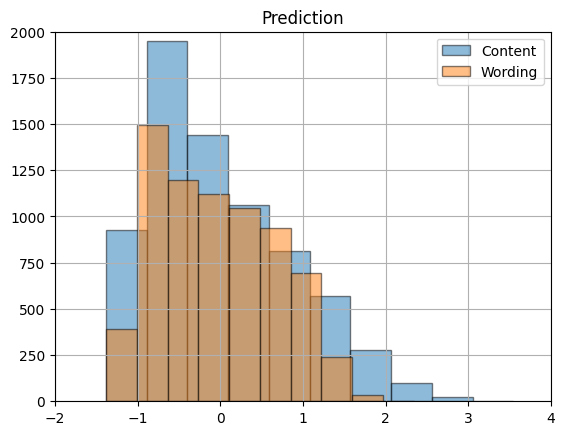

In [47]:
submission_file = pd.read_csv(submission_path)

submission_file['content'].hist(label='Content', alpha=0.5, edgecolor='k')
submission_file['wording'].hist(label='Wording', alpha=0.5, edgecolor='k')
plt.xlim([xmin, xmax])  # Set x-axis limits
plt.ylim([ymin, ymax])  # Set y-axis limits
# Adding a legend
plt.legend()
plt.title('Prediction')
plt.show()

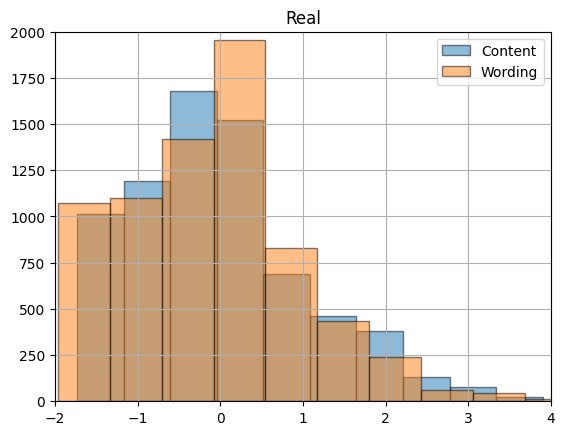

In [48]:
summaries_test['content'].hist(label='Content', alpha=0.5, edgecolor='k')
summaries_test['wording'].hist(label='Wording', alpha=0.5, edgecolor='k')
plt.xlim([xmin, xmax])  # Set x-axis limits
plt.ylim([ymin, ymax])  # Set y-axis limits
# Adding a legend
plt.legend()
plt.title('Real')
plt.show()